# Classifying Images of Distracted Drivers
> People can get distracted in various ways while driving. This tutorial shows how to classify images of distracted drivers by the kind of distraction using the fastai library. 

- badges: true
- hide_binder_badge: true
- comments: false
- author: bam098
- categories: [Kaggle, Image Classification, fastai, CNN]

![](my_images/kaggle_ddd_data.png)

Many car accidents are caused by distracted drivers. Driving assistance systems could help to reduce that number. A camera could observe the driver and initiate an alert when the driver is distracted while driving. To recognize when the driver is distracted the driving system needs to examine every image frame coming from the video recording of the camera. This ends up being an image classification problem. For every incoming image frame we need to classify whether the image shows a distracted or a non-distracted driver.

A few years ago there was a [competition](https://www.kaggle.com/c/state-farm-distracted-driver-detection/) on [Kaggle](https://www.kaggle.com/) that asked to solve a very similar problem. Although the competion is not active anymore, you can still download the dataset and submit results. The competition provides a dataset of images showing distracted drivers. However, here it was asked not to only classify distracted and non-distracted drivers but to also distinguish between the different kinds of distractions. The dataset encompasses the following classes:
- `c0`: safe driving
- `c1`: texting (right hand)
- `c2`: talking on the phone (right hand)
- `c3`: texting (left hand)
- `c4`: talking on the phone (left hand)
- `c5`: operating the radio
- `c6`: drinking
- `c7`: reaching behind
- `c8`: hair and makup
- `c9`: talking to passenger

I already showed how to download the dataset on [Google Colab](https://colab.research.google.com/) in [my last blog post](https://bam098.github.io/blog/kaggle/google%20colab/2020/03/15/kaggle-download-colab.html). I put the download into the folder `/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd`. It contains the following files and directories:
- `img` directory: folder containing the training and test images
- `sample_submission.csv`: an example file showing how to submit to Kaggle
- `driver_imgs_list.csv`: a CSV file containing the file name of each training image, its class id (`c0`, `c1`, ...) and the id of the person on the image

Before we start using a notebook in Google Colab we need to select the GPU as the hardware accelerator. Otherwise training a model will take a really long time. To do this go in Google Colab to `Runtime`, then `Change runtime type` and finally select `GPU` as `Hardware accelerator` in the upcoming menue. Now, we have GPU access to train our image classification model.

![](my_images/gcolab_gpu_menue1.png)

![](my_images/gcolab_gpu_menue2.png)

Then, we need to mount our Google Drive space again to access the data.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/state-farm-ddd/'

Mounted at /content/gdrive


I want to use the [fastai](https://fastai1.fast.ai/) library for training our model, since it makes it possible to train an image classification model in a quick and easy way. Fastai is built on top of [PyTorch](https://pytorch.org/). Both libraries are already pre-installed on Google Colab. However, to make sure that we have the lastest version of both libraries I want to re-install them. Fastai offers a script to setup its library on Google Colab. You can find more detailed setup instructions [here](https://course.fast.ai/start_colab.html).

> Important: The code shown in the blog post uses the old fastai v1 version. For the current fastai version check out the [fastai docs](https://docs.fast.ai/).

Next, we need to run some some magics. We usually should do that at the beginning of every notebook. They are responsible for showing [matplotlib](https://matplotlib.org/) plots inside the notebook and for automatic reloading the notebook if some underlying library code changes. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let's also check the versions of PyTorch and fastai.

In [0]:
import torch
import torchvision
import fastai

In [6]:
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('fastai version:      {}'.format(fastai.__version__))

torch version:       1.4.0
torchvision version: 0.5.0
fastai version:      1.0.60


Furthermore, we should also check if we really have access to the GPU. Google Colab does offer GPU access and we already enabled it. However, to make sure there aren't any problems here we can check whether a GPU is available by running the following command. 

In [7]:
torch.cuda.is_available()

True

Then, we need to import the necessary fastai libraries as well as a few other libraries like e.g. [Pandas](https://pandas.pydata.org/) that will be helpful later. 

In [0]:
from fastai.vision import *
from fastai.metrics import accuracy
import pandas as pd
import random

I'm going to use a neural network based model, since this is the current-state-of-the-art for image classification. However, training such a model also involves some randomness. For instance, the parameters (also called weights) of the model are usually intialized involving random numbers. As a result, each time you train a model you obtain a different result although you use the same dataset and hyper-parameters for model training. Usually the differences won't be too big. However, if you still want to obtain the same result every time, you can run the following commands to achieve this (read more about it [here](https://pytorch.org/docs/stable/notes/randomness.html)).

In [0]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)

Now we are ready to load the dataset and train an image classification model using fastai.

## Load Dataset

The `imgs` folder has two subfolders: `train`and `test`. The `test` folder contains the test set, which needs to be classified by our model at the end. The resulting classifications should be sumitted to Kaggle then. However, before we can do that we need to train the model first. The training set required for model training is located in the `train` folder.  

In [10]:
ds_path = Path(base_dir + 'imgs/train'); ds_path

PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train')

Let's look into that folder.

In [11]:
ds_path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c0'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c1'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c2'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c3'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c4'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c5'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c6'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c7'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c8'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/c9'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/state-farm-ddd/imgs/train/models')]

As we can see the `train` folder contains ten subfolders. Each subfolder contains images of a certain class. 

Now, we need to load all the images from all of these ten folders and split them  into a set used for training the model and a set used for validating the model. Usually we would do that by simply dividing the dataset randomly into two groups (e.g. 80% for the train set and 20% for the valid set). 

However, it's actually not a good idea to do the splitting of the dataset randomly in this case here. We rather should divide it according the drivers that are on the images. We should not have a single person that is in the training and the validation set at the same time. Instead, we should divide the dataset into two sets of images showing different groups of people. The reason is that otherwise our model could [overfit](http://neuralnetworksanddeeplearning.com/chap3.html#overfitting_and_regularization) later. It could learn to focus on specific properties of the people (e.g. clothes, hair) instead of the state of distraction. However, the properties of the people are irrelevant for the classification problem here. The states of distraction are important. 

> Tip: You can read more about how to create validation sets in general in this really nice [blog post](https://www.fast.ai/2017/11/13/validation-sets/) written by [Rachel Thomas](https://twitter.com/math_rachel) from [fast.ai](https://www.fast.ai/).

But how can we do the separation depending on the drivers? As already mentioned above the CSV file `driver_imgs_list.csv` contains an id of a person for each image showing that person. This represents our drivers. So, let's look at this file using Pandas. The person id is represented by the `subject` column.

In [12]:
df = pd.read_csv(base_dir + 'driver_imgs_list.csv'); df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


We have three columns:
- `subject`: the id of the person on the image
- `classname`: the name of the class represeting the state of distraction
- `img`: the file name of the image

Let's see how many images we have in total. To get this number we need to count the number of rows of the table above.

In [13]:
n = df.shape[0]
print('total: {}'.format(n))

total: 22424


Next, let's check how many different drivers (i.e. subjects) we have.



In [14]:
df_by_subject = df.groupby('subject')
unique_subjects = list(df_by_subject.groups.keys())
num_subjects = len(unique_subjects)

print('number of subjects: {}'.format(num_subjects))
print('subjects: {}'.format(unique_subjects))

number of subjects: 26
subjects: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Let's choose a certain amount of drivers for the validation set and use the remaining drivers for the training set. Usual splits into training and validation sets in percent are 80/20, 70/30 or 60/40. For now, let's take 20% of the drivers for validation and 80% for training and see how good we can get with this split. The 20% for the validation set should be chosen randomly. Therefor we can use the `random` package from Python.



In [15]:
valid_frac = 0.2
random.shuffle(unique_subjects)

valid_subjects = unique_subjects[:int(num_subjects * valid_frac)]

print('valid subjects: {}'.format(valid_subjects))

valid subjects: ['p047', 'p002', 'p072', 'p052', 'p022']


We chose 20% of the drivers which makes five. However, we also need to make sure that there are a sufficient number of images showing these five drivers compared to the images showing the remaining drivers. If our five chosen drivers only appear on e.g. 50 images, our train-test-split will be quite bad, since this is a tiny amount of images compared to the total amount of 22424. As a result, let's check on how many images our five drivers appear.

In [16]:
df_valid = df.loc[df['subject'].isin(valid_subjects)]
n_valid = df_valid.shape[0]

print('valid total: {} ({}%)'.format(n_valid, round(100. * n_valid / n, 2)))

valid total: 3879 (17.3%)


The fraction of the images is not quite 20% but 17% is okay for now. Next, let's also check whether there are enough images per class. It won't be good if our validation set doesn't contain a sufficient amount of images of each class.

In [17]:
df_valid.groupby(['classname']).size().reset_index(name='counts')

,classname,counts
0,c0,420
1,c1,427
2,c2,415
3,c3,400
4,c4,402
5,c5,371
6,c6,407
7,c7,325
8,c8,316
9,c9,396


Okay, the amount of images per class don't differ too much between the different classes. So, our validation set seems to be okay. As a result, we can finally load the training and the validation set now. 

As I already mentioned above I want to use the fastai library to load the data. The fastai library offers several ways to do that. However, since we already have a Pandas dataframe, it seems to me that loading the data using that dataframe is the easiest option. Moreover, through a dataframe we can also handle the creation of the validation set according to the drivers in an easy way. 

Before we can load the data we need to adjust our dataframe a bit. The values of the `img` column need to include the path to each image and not only the image file name. Then, to create a validation set according to the drivers later we need to add a new column with boolean values to our dataframe indicating whether an image belongs to the validation set or not (if not, it belongs to the training set). I want to call this new column `is_valid`. After creating this new column we can remove the `subject` column from the dataframe.

> Warning: A new version of the fastai library is going to be released in [July 2020](https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/). It sounds like that there will be quite some changes in the new version. As a result, the code in this tutorial using fastai v1 will require to be updated in the future to also work under fastai v2. 

In [0]:
# adjust img column to contain the path to each image
df['img'] =  df['classname'] + '/' + df['img']

# add is_valid column to indicate which images belong to the valid set
df['is_valid'] = df['subject'].isin(valid_subjects)

# remove subjects column
df = df.drop(columns=['subject'])

In [19]:
df

,classname,img,is_valid
0,c0,c0/img_44733.jpg,True
1,c0,c0/img_72999.jpg,True
2,c0,c0/img_25094.jpg,True
3,c0,c0/img_69092.jpg,True
4,c0,c0/img_92629.jpg,True
...,...,...,...
22419,c9,c9/img_56936.jpg,False
22420,c9,c9/img_46218.jpg,False
22421,c9,c9/img_25946.jpg,False
22422,c9,c9/img_67850.jpg,False


Now we can load the dataset using the [data blocks API](https://fastai1.fast.ai/data_block.html) of fastai. This encompasses several building blocks:
- Create an image list from the `img` column (index: 1) of our dataframe 
- Split the dataset into training and validation set using the `is_valid` column (index: 2) of the dataframe
- Load the labels for each image from the `classname` column (index: 0) of the dataframe
- Apply any transformations to the images like e.g. data augmentation or resizing of the images
- Specify a certain batch size and create a [databunch object](https://fastai1.fast.ai/data_block.html#LabelLists.databunch) 
- Normalize the images


Due to technical reasons, it is necessary that all of our images are of the same size for model training. Moreover, they also shouldn't be too large. As a result, we need to resize all of them. Since I want to use [transfer learning](https://fastai1.fast.ai/vision.learner.html#Transfer-learning) later to train our model, it is usually a good idea to set the image size to 224x224x3. This is caused by the fact that most pre-trained models that are used for transfer learning are trained with images of this size. However, since the images of our dataset contain a lot of details that are import for classifying them, I want to go a bit bigger here. As a result, I decided to use a size of 299x299x3. I probably don't want to go bigger than that for now, because bigger images also increase model training time and memory consumption later.

When training the model, the images are fed into the network in batches. The batch size is actually a hyper-parameter that will influence model training. Usually smaller batch sizes have a [regularization](http://neuralnetworksanddeeplearning.com/chap3.html#overfitting_and_regularization) effect on the model. However, I'm going to use the [1-cycle-policy](https://sgugger.github.io/the-1cycle-policy.html) to train our model, which should be used together with a batch size as large as possible (read this [paper](https://arxiv.org/abs/1803.09820) for more details). As a result I set the batch size to 32. You can also try to increase the batch size, but at some point you will run out of GPU memory.

However, besides feeding the original images into the neural network it is also a good idea to change these images a little bit and use the resulting new images for training as well. This way we are able to get more variation into our training set which is an additonal way to avoid model overfitting. There are many ways to change the images. All of these techniques are summarized under the term data augmentation. I don't want to go into too much detail now, but you can read more about it [here](https://fastai1.fast.ai/vision.transform.html#Data-augmentation). Fastai offers some standard data augmentation operations which we can load with the method `get_transforms`. The only operation which we might not want to use is flipping the images. Otherwise our model might get confused with e.g. images of the classes `texting (right hand)` and `texting (left hand)`.

After creating these additional images through data augmentation, we need to normalize our whole dataset (i.e. our original images and the images created through data augmentation) in a last step. Normalization often improves model training. You can find more information about how to normalize data and why it is useful [here](https://www.youtube.com/watch?v=FDCfw-YqWTE) and [here](https://en.wikipedia.org/wiki/Standard_score). For now it is only important to know that we need the following two statistics to normalize our images: a mean to shift and a standard deviation to scale the image data. We can either calculate mean and standard deviation from our own data or we can use a pre-computed mean and standard deviation from a standard dataset like [ImageNet](https://en.wikipedia.org/wiki/ImageNet). Since ImageNet has a lot more data, its mean and standard deviation are probably more accurate. Furthermore, our pre-trained model that we are going to use was also pre-trained on ImageNet. Thus it probably also makes sense to use its image statics.

Okay, let's see how all this looks in code using the fastai data block API.

In [0]:
bs = 32
tfms = get_transforms(do_flip=False)

data = (ImageList
  .from_df(df, ds_path, cols=1)
  .split_from_df(col=2)
  .label_from_df(cols=0)
  .transform(tfms=tfms, size=299)
  .databunch(bs=bs)
).normalize(imagenet_stats)

> Tip: You can find information about the data block API of fastai v1 in the [its documentation](https://fastai1.fast.ai/data_block.html). Furthermore, there is also already some information about the data block API of fastai v2 in this [blog post](https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html) of [Zach Mueller](https://twitter.com/TheZachMueller) and this [paper](https://arxiv.org/abs/2002.04688) from [Jeremy Howard](https://twitter.com/jeremyphoward) and [Sylvain Gugger](https://twitter.com/GuggerSylvain). 

Now we can check which different classes our loaded data has. These should be the ten classes mentioned above.

In [21]:
data.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

We can also look at some sample images of the dataset.

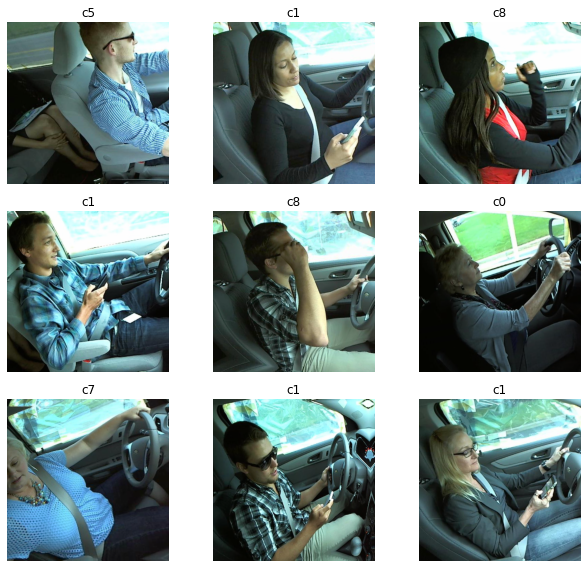

In [22]:
data.show_batch(rows=3, figsize=(9,8))

To make sure we loaded all images of the dataset we can print the size of the training and validation set.

In [23]:
len(data.train_ds)

18545

In [24]:
len(data.valid_ds)

3879

As we can see our training set contains 18545 images and our validation set contains 3879 images. In total we have 22424 images. This means we loaded all the images. Moreover, our splitting of the dataset is correct as well. Now, we can train a model using this data.

## Train Model

Before we can train a neural network based model we need to decide which network architecture we want to use. For image classification we usually use a [Convolutional Neural Network](https://www.youtube.com/watch?v=bNb2fEVKeEo) (often abbreviated with CNN). The most common CNN based architecture for image classification nowadays is a [Residual Network](https://arxiv.org/abs/1512.03385) based architecture (often abbreviated with ResNet). Fastai offers such an architecture in [several sizes](https://fastai1.fast.ai/vision.models.html). I decided to use a ResNet50 (i.e. it consists of 50 layers) here, since it is a standard model architecture for image classification. 

Furthermore, as already mentioned above I don't want to train a model from scratch, since this could be very complicated. I rather want to use a pre-trained model. This process is called transfer learning. The advantage of using [transfer learning](https://fastai1.fast.ai/vision.learner.html#Transfer-learning) is that we don't need to start training our model using zero knowledge. Although the pre-trained model was trained with a totally different dataset (usually ImageNet) it probably contains at least some useful information. To see this we need to understand how neural network based training works. Again, I don't want to go into too much detail here, but you can think of it as follows. To train a neural network the network needs to look at many different images and try to identify class specific features in these images in a hierachical way. It starts by searching for low level features like e.g. edges and then combines these to simple shaps. These simple shaps are further combined to more complex shapes and so on. At the end the network hopefully finds highly characteristic features for each class (you can read more about it [here](https://arxiv.org/abs/1311.2901)). Although these characteristic features most likely won't be useful for our dataset, the lower level features (e.g. edges) probably will be. Thus, transfer learning is always recommended to use. As a result, in fastai when selecting a standard model architecture it will use the corresponding pre-trained model as default.

But how can we train a model with fastai? To be able to train a model we need to create a model [learner](https://fastai1.fast.ai/basic_train.html) first. It requires our data, the model architecture (with the pre-trained model weights) and a [metric](https://fastai1.fast.ai/metrics.html) to evaluate the model as input. I decided to use [accuracy](https://en.wikipedia.org/wiki/Precision_and_recall) as the metric here, since it is a standard metric that is often used in practice.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

To display the model architecture we simply can run the following code.

In [26]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

When training a model we need to set several hyper-parameters. I already mentioned the batch size. However, there are a few more hyper-parameters that we can set. Fastai uses some default values for most of them which I don't want to change for now. The only hyper-parameter we do need to set besides the batch size is the most important one: the learning rate. The learning rate is responsible for how fast we can train our model. The higher our learning rate the faster we usually can train the model. But be careful! The value for the learning rate also mustn't be too high, because learning rates that are too high could corrupt model training.

There are several ways to set the learning rate. We will use a technique called [1-cycle-policy](https://sgugger.github.io/the-1cycle-policy.html) here that usually gives quite promising results. Again, I don't want to go into too much detail here how it exactly works.  Fastai handles it for us, so that we usually don't need to care about it. As a result, in the following I only want to give a brief overview here.

As I already mentioned, during model training we show the network every image of the dataset. The model can use the information from the images to improve a little bit. Then we show it all the images again and it can improve a little bit further. The time between showing all the images to the model and using the information of the images to improve the model is called an epoch. Usually we use several epochs to train a model. Sometimes we even need many epochs. This might be necessary because the classification problem is quite difficult. However, another reason could be that we didn't choose good values for the hyper-parameters. Especially the learning rate. As I already mentioned above a too small learning rate could result in very slow training. But how can we find a good learning rate? The 1-cycle-policy does it as follows. It starts with a certain value for the learning rate. Then, it linearly increases it to a maximum value after half of our total number of specified epochs. From there the learning rate is decreased again during the remaining epochs. There are a lot more details here. If you are interested, you can read more about it in this [blog post](https://sgugger.github.io/the-1cycle-policy.html). 

As I already mentioned, since we use the fastai library, we don't need to care about how the 1-cycle-policy works. However, the only thing we do need to specify is the maximum learning rate for it. To find this maximum learning rate we can use a learning rate finder. A learning rate finder looks for the maximum learning rate that is still useful for training. It trains a model for a few batches while increasing the learning rate. In fastai we can use the learning rate finder in the following way.

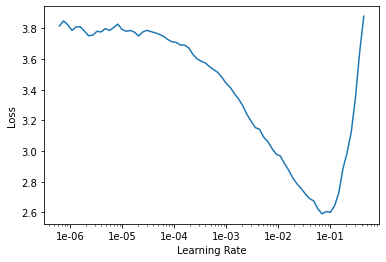

In [27]:
learn.lr_find()
learn.recorder.plot()

The learning rate finder gives us a plot showing the increasing learning rates and their corresponding losses. At some point the losses explode. But what are losses? 

Losses show us how good our model currently is (a lower value is better here). So, isn't it similar to the accuracy then? Yes, it is. However, the loss is used by the model to see how good it is and to improve itself. For mathematical reasons, metrics like e.g. the accuracy cannot be used for this. Metrics are only used for humans, since they are more easily human-interpretable than losses.

Okay, let's get back to our plot! The minimum loss value is reached with a learning rate of 0.1. After that the loss explodes which means that a learning rate greater than 0.1 is too high. So, should we use 0.1 as our maximum learning rate? No! We rather should choose a value ten times smaller than the minimum as our maximum learning rate. This results in a value of 0.01. You can read more about why that is [here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate).

Okay, let's train our model for a few epochs using the 1-cycle-policy with a maximal learning rate of 0.01. Usually it's good to train the model for at least four epochs. Let's use a few more epochs than four. 

> Warning: I observed that sometimes training on Google Colab can be very slow. I'm not sure what the problem is. The only reason I can think of is that many people use Google Colab at the same time. However, independently of what the reason is, when training is very slow, you just need to wait a bit and try again.

In [28]:
learn.fit_one_cycle(6, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.437207,0.942094,0.769013,06:27
1,0.374510,0.841367,0.766177,06:25
2,0.191100,0.506396,0.870070,06:24
3,0.079668,0.402396,0.886311,06:29
4,0.059663,0.453178,0.865687,06:24
5,0.029207,0.391314,0.882186,06:27


We were able to reach an accuracy of more than 88%. That's not too bad. Let's save our model.

In [0]:
learn.save('stage-1')

Through model training we tried to find good model parameters (i.e. weights). With the right parameters the model will be able to find characteristic features for each class. 

However, we actually didn't train all of the model parameters. Why is that? Well, before using a pre-trained model the last layer of that model needs to be exchanged. Fastai does this for us. This is necessary, since the last layer of a network is specific to the classes. However, the classes of the data used to train the pre-trained model are most likely different to the classes of our problem. As a result, we definitely want to train the parameters of this new last layer to adapt the pre-trained model to our classification problem. However, at the same time the  model parameters of all the other layers are kept frozen by fastai by default.

After training only the parameters of the last layer for a few epochs, we can unfreeze the parameters of all the other layers and train them as well. This procedure often works better than immediately unfreezing and training all model parameters. However, when training the whole network we shouldn't use the same maximum learning rate for all of layers. The learning rate that we found with the help of the learning rate finder should still be used for the last layer. However, the maximum learning rate for the first layers should be smaller. Why is that? Well, the first layers that try to find low level features (e.g. edges) usually require less adjustments than the last layers that try to find class specific features. As a result, fastai divides the network layers into three groups:
- For the last layer group you should use the learning rate found through the learning rate finder
- For the first layer group you could use e.g. a learning rate 10 or 20 times smaller than the one used by the last layer group (read more about how to set it [here](https://arxiv.org/abs/1803.09820))
- For the second layer group fastai finds a value between the learning rate of the first and the last layer group automatically

Okay, let's unfreeze the network and train the model for 12 more epochs.

In [30]:
learn.unfreeze()
learn.fit_one_cycle(12, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.157773,0.577920,0.845837,06:37
1,0.187176,0.646526,0.815932,06:39
2,0.166968,0.645245,0.822377,06:37
3,0.137360,0.594758,0.873421,06:35
4,0.148992,0.591642,0.858469,06:37
5,0.095911,0.674571,0.851766,06:32
6,0.065731,0.527851,0.853828,06:34
7,0.053018,0.345897,0.916989,06:35
8,0.017212,0.406156,0.894818,06:33
9,0.010215,0.266608,0.939417,06:33


We were able to reach an accuracy of more than 93%. We could improve our model even further! Let's save the model.

In [0]:
learn.save('stage-2')

## Model Evaluation

Now, let's evaluate our model. What mistakes does our model make? In which cases is it most wrong? To find this out we can use the [ClassificationInterpretation class](https://fastai1.fast.ai/vision.learner.html#ClassificationInterpretation) offered by fastai.

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

Let's print the images with the top losses first. These are the image our model is most wrong about.

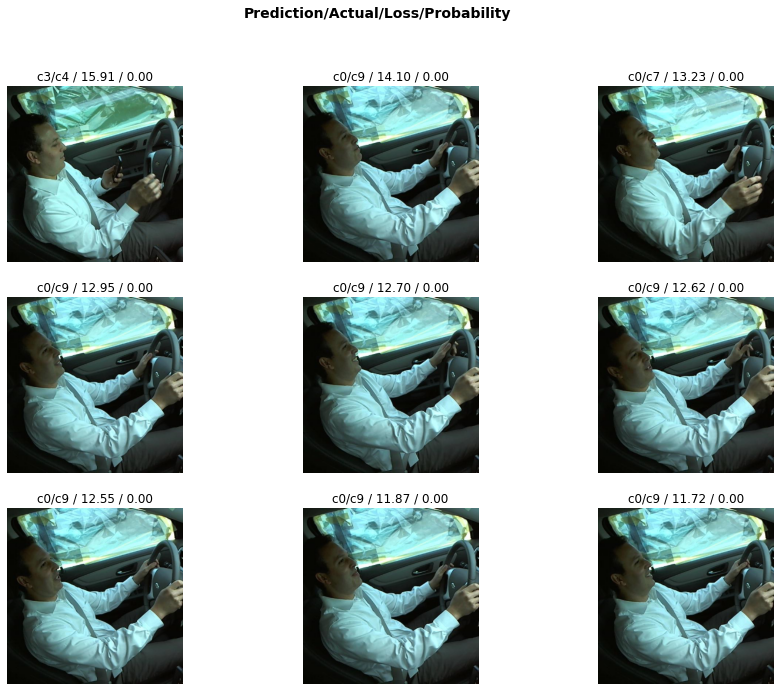

In [33]:
interp.plot_top_losses(9, figsize=(15,11))

As we can see our model mostly seems to have problems to distinguish between the classes `c0` (safe driving) and `c9` (talking to passenger). However, when looking at the images, this seems to be a difficult task even for humans. Since the driver does not need to look at the passanger while talking to him, it is difficult to tell if he really talks to him or not. 

After getting this first impression of our model, let's look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

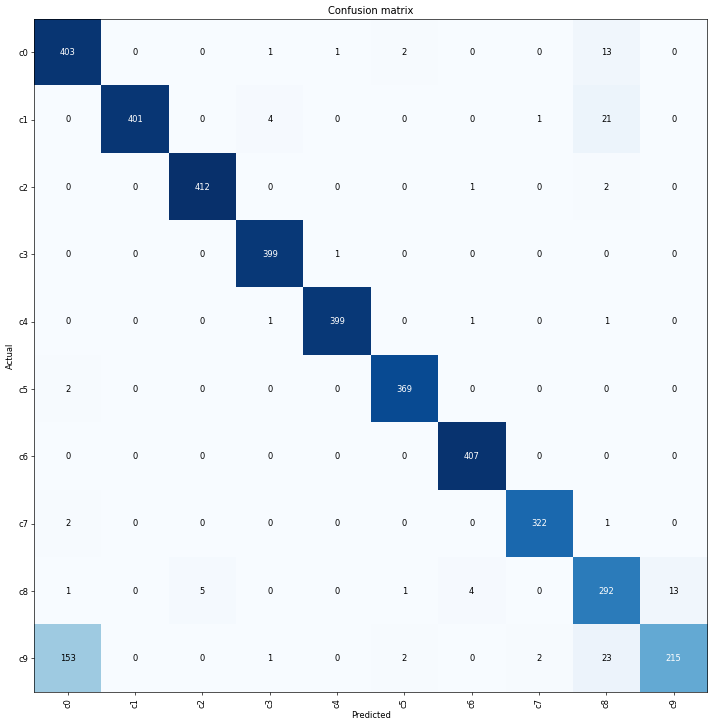

In [34]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Alternatively, we can also print the results of the confusion matrix as a list in the following way.

In [35]:
interp.most_confused(min_val=2)

[('c9', 'c0', 153),
 ('c9', 'c8', 23),
 ('c1', 'c8', 21),
 ('c0', 'c8', 13),
 ('c8', 'c9', 13),
 ('c8', 'c2', 5),
 ('c1', 'c3', 4),
 ('c8', 'c6', 4),
 ('c0', 'c5', 2),
 ('c2', 'c8', 2),
 ('c5', 'c0', 2),
 ('c7', 'c0', 2),
 ('c9', 'c5', 2),
 ('c9', 'c7', 2)]

Here we can see again that our model really seems to have most problems with class `c0` and `c9`. However, despite this issue our model seems to be quite good already.

And we are done! In another blog post I want show how to finally predict the classes for our test set using our model and how to submit the resulting predictions to Kaggle.